<a href="https://colab.research.google.com/github/fikrinotes/LSTM-IDS/blob/main/Final_Project_IDS_with_Autoencoder_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.a

chethuhn_network_intrusion_dataset_path = kagglehub.dataset_download('chethuhn/network-intrusion-dataset')
fikrimulyanasetiawan_rnn_model_path = kagglehub.dataset_download('fikrimulyanasetiawan/rnn-model')
fikrimulyanasetiawan_encoder_path = kagglehub.dataset_download('fikrimulyanasetiawan/encoder')

print('Data source import complete.')


# Intrusion Detection System

## Import Library

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Preprocessing Data

In [ ]:
# Fungsi untuk membaca dan preprocessing setiap file
def read_and_clean_file(file_path):
    print(f"Membaca file: {file_path}")
    df = pd.read_csv(file_path, low_memory=False, sep=",")

    # Bersihkan nama kolom dari whitespace
    df.columns = df.columns.str.strip()

    # Hapus kolom yang tidak diperlukan
    redundant = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
                 'Destination Port', 'Protocol', 'Timestamp']
    df = df.drop(redundant, axis=1, errors='ignore')

    # drop baris yang tidak punya label
    df.dropna(subset = ['Label'], inplace=True)

    # Handling missing values dan infinite values
    df = df.replace([np.inf, -np.inf], np.nan)

    return df


# Baca semua file CSV dari folder
folder_path = '/kaggle/input/network-intrusion-dataset'
data1 = "/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv"
data2 = "/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv"
data3 = "/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv"
data4 = "/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
data5 = "/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
data6 = "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv"
data7 = "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
data8 = "/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"


# Baca semua file CSV dari folder
all_files = [data2, data3, data4, data5, data6, data7, data8]

# Membaca file dan mengkonversi data file menjadi dataframe
dataframes = []
for file in all_files:
    # file_path = os.path.join(folder_path, file)
    df = read_and_preprocess_file(file)
    dataframes.append(df)

Membaca file: /kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv


NameError: name 'redundant_row' is not defined

In [ ]:
# Menggabungkan semua dataframe
print("Menggabungkan semua file...")
df = pd.concat(dataframes, ignore_index=True)
try:
    print("Semua file dataset berhasil digabungkan!")
except:
    print("Error! file dataset tidak berhasil digabungkan")

In [ ]:
dataframe = df.copy(deep=True)

In [ ]:
dataframe['Label'] = dataframe['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:
df.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [ ]:
corr_matrix = dataframe.corr(method='pearson')

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [ ]:
corr_matrix

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Flow Duration,1.000000,0.020364,0.019064,0.059987,0.015570,0.267670,-0.102557,0.144402,0.232109,0.509018,-0.222822,0.480270,0.458303,-0.025471,-0.127027,0.566851,0.763140,0.801550,0.056943,0.998731,0.569587,0.750133,0.801284,0.194876,0.797508,0.408199,0.519618,0.575499,0.200022,-0.011264,NaN,-0.005342,NaN,-0.000030,-0.000493,-0.117395,-0.085067,-0.232143,0.525653,0.444553,0.470425,0.292888,0.220580,-0.011264,0.008541,0.120638,0.059514,-0.098897,-0.005342,0.008503,-0.156589,0.422547,0.144402,0.480270,-0.000030,NaN,NaN,NaN,NaN,NaN,NaN,0.020364,0.060071,0.019064,0.015569,0.091863,-0.018153,0.015094,-0.000509,0.185997,0.229857,0.285030,0.122846,0.785934,0.246418,0.797915,0.755633,NaN
Total Fwd Packets,0.020364,1.000000,0.999014,0.299808,0.996279,0.008333,-0.002797,0.000045,0.001317,0.021515,-0.005538,0.019769,0.005840,0.000368,-0.002672,-0.000977,-0.000507,0.002086,-0.000490,0.020135,-0.000996,-0.000002,0.001798,-0.001103,0.023920,-0.000578,0.000671,0.003147,-0.000961,0.001894,NaN,-0.000117,NaN,0.000342,0.012047,-0.002469,-0.001797,-0.006107,0.020789,0.022770,0.011004,0.004825,-0.001370,0.001894,0.000447,0.006196,0.001364,-0.003418,-0.000117,0.000445,0.000830,0.020508,0.000045,0.019769,0.000342,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.300230,0.999014,0.996271,0.004093,-0.000067,0.843251,-0.000204,0.025222,0.008646,0.021702,0.024526,0.001544,0.000729,0.001628,0.001403,NaN
Total Backward Packets,0.019064,0.999014,1.000000,0.292893,0.993421,0.008018,-0.002395,-0.000306,0.000975,0.021261,-0.004798,0.019809,0.005495,0.000269,-0.002818,-0.001409,-0.001071,0.001532,-0.000519,0.018810,-0.001240,-0.000592,0.001223,-0.000981,0.023283,-0.000774,0.000480,0.003213,-0.000944,0.001691,NaN,-0.000124,NaN,0.000652,0.012062,-0.002669,-0.001465,-0.005537,0.020480,0.023092,0.010827,0.004767,-0.001230,0.001691,0.000295,0.005858,0.001010,-0.002730,-0.000124,0.000294,0.003315,0.020846,-0.000306,0.019809,0.000652,NaN,NaN,NaN,NaN,NaN,NaN,0.999014,0.293315,1.000000,0.993414,0.003751,-0.000129,0.837865,0.000018,0.024381,0.006684,0.019872,0.024676,0.001067,0.000383,0.001093,0.000983,NaN
Total Length of Fwd Packets,0.059987,0.299808,0.292893,1.000000,0.286435,0.188771,0.001248,0.179182,0.153514,0.016942,-0.023348,0.013277,0.006091,0.002913,-0.012878,0.005471,0.014895,0.025256,-0.002368,0.059305,0.007203,0.022278,0.025565,-0.004803,0.073345,0.008985,0.035495,0.040969,-0.003818,0.010342,NaN,-0.000606,NaN,-0.001365,0.003593,-0.011833,-0.009077,-0.022934,0.069555,0.076013,0.053981,0.032932,-0.005647,0.010342,0.004669,0.034356,-0.000248,0.000189,-0.000606,0.004660,-0.009408,0.071270,0.179182,0.013277,-0.001365,NaN,NaN,NaN,NaN,NaN,NaN,0.299808,0.999999,0.292893,0.286442,0.027151,0.011477,0.349983,-0.001

In [ ]:
# Korelasi setiap fitur dengan label
target_corr = corr_matrix['Label'].abs().sort_values(ascending=False)

# Pilih fitur dengan korelasi > threshold (misal: top 20%)
threshold = 0.05  # Ambang minimal korelasi
high_corr_features = target_corr[target_corr > threshold].index.tolist()

# Hapus 'Label' jika termasuk
high_corr_features = [f for f in high_corr_features if f != 'Label']

print(f"Selected features: {len(high_corr_features)}")
print(high_corr_features)

Selected features: 0
[]


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [ ]:
# Buat matriks korelasi hanya untuk fitur terpilih
high_corr_df = dataframe[high_corr_features]
feature_corr = high_corr_df.corr().abs()

# Identifikasi pasangan fitur dengan korelasi tinggi
to_drop = set()
for i in range(len(feature_corr.columns)):
    for j in range(i):
        if feature_corr.iloc[i, j] > 0.8:  # Threshold multikolinearitas
            col_i = feature_corr.columns[i]
            col_j = feature_corr.columns[j]

            # Bandingkan korelasi dengan target, hapus yang lebih rendah
            if target_corr[col_i] > target_corr[col_j]:
                to_drop.add(col_j)
            else:
                to_drop.add(col_i)

# Final feature selection
final_features = [f for f in high_corr_features if f not in to_drop]

print(f"\nFinal features after multicollinearity check: {len(final_features)}")
print(final_features)


Final features after multicollinearity check: 0
[]


In [ ]:
df.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776134e+06,1.776134e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1776724.0,1.776724e+06,1776724.0,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1776724.0,1776724.0,1776724.0,1776724.0,1776724.0,1776724.0,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06,1.776724e+06
mean,2.044859e+07,1.132848e+01,1.288430e+01,7.080220e+02,2.040554e+04,2.692504e+02,2.127198e+01,7.407654e+01,9.121015e+01,1.262360e+03,4.657640e+01,4.343416e+02,4.950533e+02,3.843907e+05,1.570943e+04,1.740057e+06,4.191564e+06,1.333041e+07,1.614324e+05,2.005309e+07,3.517964e+06,4.893169e+06,1.315283e+07,1.181230e+06,1.303862e+07,2.334902e+06,2.126102e+06,6.457807e+06,1.169505e+06,3.744194e-02,0.0,1.294517e-05,0.0,-3.749532e+04,-2.716138e+03,1.198527e+04,3.792668e+03,1.810718e+01,1.373998e+03,2.387449e+02,4.270607e+02,7.516428e+05,3.898073e-02,3.744194e-02,3.455798e-04,2.797683e-01,2.903884e-01,8.015820e-02,1.294517e-05,3.467055e-04,7.117059e-01,2.648125e+02,7.407654e+01,4.343416e+02,-3.749532e+04,0.0,0.0,0.0,0.0,0.0,0.0,1.132848e+01,7.080053e+02,1.288430e+01,2.040500e+04,6.752446e+03,1.996872e+03,6.294815e+00,-3.298363e+03,1.095195e+05,5.264601e+04,2.006925e+05,7.981437e+04,1.221485e+07,7.423639e+05,1.277307e+07,1.164054e+07
std,3.814850e+07,8.110867e+02,1.083647e+03,1.214231e+04,2.454552e+06,8.614631e+02,6.939033e+01,2.251946e+02,3.418177e+02,2.327450e+03,7.265619e+01,7.160782e+02,1.014683e+03,6.191377e+06,1.069682e+05,4.831652e+06,9.353802e+06,2.906884e+07,2.968230e+06,3.812544e+07,1.048063e+07,1.167054e+07,2.918775e+07,9.309517e+06,3.237414e+07,9.820166e+06,7.598989e+06,2.023401e+07,9.108988e+06,1.898422e-01,0.0,3.597918e-03,0.0,2.650045e+07,1.801382e+06,9.613522e+04,2.789681e+04,2.676287e+01,2.414968e+03,3.559690e+02,7.545232e+02,2.029847e+06,1.935491e-01,1.898422e-01,1.858657e-02,4.488854e-01,4.539417e-01,2.715380e-01,3.597918e-03,1.861681e-02,7.520701e-01,3.860408e+02,2.251946e+02,7.160782e+02,2.650045e+07,0.0,0.0,0.0,0.0,0.0,0.0,8.110867e+02,1.212458e+04,1.083647e+03,2.454507e+06,1.363606e+04,8

In [ ]:
df['Label']

### Pembersihan data duplikat

In [ ]:
# ganti nama kolom dengan cara hapus whitespaces
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

# informasi data duplikat
dups = df[df.duplicated()]
print(f'Number of duplicates: {len(dups)}')

In [ ]:
df.shape

In [ ]:
# Hapus data duplikat
df.drop_duplicates(inplace = True)
df.shape

## Informasi Umum Dataset

In [ ]:
# Menampilkan informasi dataset
print("\nInformasi Dataset:")
print(f"\nJumlah total data: {len(df)}")
print(f"Jumlah fitur : {len(df.columns)}")
print("\nDistribusi Label sebelum preprocessing:")

# tabel distribusi label
def create_distribution_table(df):
    label_dist = pd.DataFrame(df['Label'].value_counts())
    label_dist['percentage'] = df['Label'].value_counts()/len(df)
    return label_dist

create_distribution_table(df)

In [ ]:
df["Label"] = df["Label"].where(df["Label"] == "BENIGN", "ANOMALY")

In [ ]:
df["Label"].unique()

In [ ]:
df

In [ ]:
# Menampilkan informasi dataset
print("\nInformasi Dataset:")
print(f"\nJumlah total data: {len(df)}")
print(f"Jumlah fitur : {len(df.columns)}")
print("\nDistribusi Label setelah preprocessing:")

create_distribution_table(df)

## Pemisahan Data Fitur (X) dan Ouput (y)

In [ ]:
df[final_features].info()

In [ ]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
X = df[final_features]
y = df["Label"]

In [ ]:
X

## Training-Test Split

In [ ]:
tss = TimeSeriesSplit(n_splits=7)
print(tss)

In [ ]:
#X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
train_index, test_index = [], []
for i, (train_interval, test_interval) in enumerate(tss.split(X)):
    print(f"fold {i}:")
    print(f"  Train: index : from {train_interval.min()} up to {train_interval.max()}")
    print(f"  Test:  index=from {test_interval.min()} up to {test_interval.max()}")
    print(f"  Jumlah kelas pada training set : {y.iloc[train_interval].nunique()}")
    print(f"  Jumlah kelas pada testing set : {y.iloc[test_interval].nunique()}")
    train_index, test_index = train_interval, test_interval


In [ ]:
# Split dataset dengan stratifikasi
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test  = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_test.value_counts()

In [ ]:
y_train.value_counts()

## Transformasi Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

### Penanganan Missing Values, Normalisasi Data dan Label Encoding

In [ ]:
# imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
print("fitting imputer...")
imputer.fit(X_train)
print("selesai!")

# scaler
scaler = StandardScaler(copy=False)
print("\nfitting scaler...")
scaler.fit(X_train)
print("selesai!")

# label encoder (le)
le = LabelEncoder()
print("\nfitting label encoder...")
le.fit(y_train.astype(str))
print("selesai!")

In [ ]:
df["Label"].value_counts()

In [ ]:
def transform_data(X, y, scaler, imputer, le):
    # Handling missing values untuk dataset training
    print("\nMenangani missing values...")
    X = imputer.transform(X)
    print("selesai!")

    # Normalisasi Data
    print("\nMelakukan normalisasi data...")
    X = scaler.transform(X)
    print("selesai!")

    # One-hot encoding untuk target (karena multi-kelas)
    num_classes = len(le.classes_)
    print("\nMelakukan one-hot encoding...")
    y = le.transform(y)
    y = tf.keras.utils.to_categorical(y, num_classes)
    print("selesai!")

    return X, y

In [ ]:
y_train

In [ ]:
num_classes = len(le.classes_)

In [ ]:
num_classes

In [ ]:
## Transformasi Data Training
X_train, y_train = transform_data(X_train, y_train, scaler, imputer, le)

In [ ]:
le.classes_

In [ ]:
y_train

In [ ]:
for i, label in enumerate(le.classes_):
    print(f"i : {i} , label : {label}")

In [ ]:
# Menampilkan informasi kelas
print("\nKelas yang terdeteksi:")
for i, label in enumerate(le.classes_):
    count = (df["Label"] == i).sum()
    print(f"{label}: {count} samples (encoded as {i})")


### Penggunaan TPU

In [ ]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)


## Konstruksi Model Autoencoder

In [ ]:
y_test

In [ ]:
# Transformmasi data testing
X_test, y_test = transform_data(X_test, y_test, scaler, imputer, le)

In [ ]:
# # Membuat Autoencoder
# input_dim = X_train.shape[1]
# encoding_dim = 40  # Meningkatkan dimensi encoding karena data lebih kompleks. saran : 64

# # Encoder
# input_layer = layers.Input(shape=(input_dim,))

# encoded = layers.Dense(256, activation='relu')(input_layer)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# encoded = layers.Dense(128, activation='relu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# encoded = layers.Dense(64, activation='relu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# # Bottleneck
# encoded = layers.Dense(encoding_dim, activation='linear')(encoded)

# # Decoder
# decoded = layers.Dense(64, activation='leaky_relu')(encoded) # coba leaky_relu
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(128, activation='leaky_relu')(decoded)
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(256, activation='leaky_relu')(decoded)
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(input_dim, activation='linear')(decoded)

# # Model Autoencoder
# autoencoder = Model(input_layer, decoded)
# encoder = Model(input_layer, encoded)

# # Compile dengan learning rate yang sesuai
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# autoencoder.compile(optimizer=optimizer, loss='mse')

In [ ]:

# # Training Autoencoder dengan early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# print("\nTraining Autoencoder...")
# # history_autoencoder = autoencoder.fit(X_train, X_train,
# #                                     epochs=50,
# #                                     batch_size=512,  # Meningkatkan batch size
# #                                     shuffle=True,
# #                                     validation_split=0.2,
# #                                     callbacks=[early_stopping])
# history_autoencoder = autoencoder.fit(X_train, X_train,
#                                     epochs=200,
#                                     batch_size=256,
#                                     validation_data=(X_test, X_test))


In [ ]:
# # Mendapatkan encoded features
# X_train_encoded = encoder.predict(X_train)

In [ ]:
# plt.plot(history_autoencoder.history['loss'], label='Training Loss')
# plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
# plt.title('Autoencoder Training History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig("ae_plot_history")

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(autoencoder, to_file='model.png')

In [ ]:
# autoencoder.summary()

## Konstruksi Model LSTM

In [ ]:
y_test.shape

In [ ]:
# Membuat model LSTM untuk multi-kelas dengan data dari Autoencoder
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(input_dim,)), # ini encoding_dim (sebenarnya)
    layers.Reshape((input_dim, 1)),
    layers.LSTM(256, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(128),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer untuk multi-kelas, gunakan num_classes utk jumlah neuron
]) # jika cuma 2 kelas (seperti deteksi anomali, cukup 1 neuron pada layer output)

# Compile RNN
rnn_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Training RNN dengan early stopping
early_stopping_rnn = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

print("\nTraining RNN...")
history_rnn = rnn_model.fit(X_train, y_train,
                           epochs=50,
                           batch_size=512,
                           validation_data=(X_test, y_test),
                           callbacks=[early_stopping_rnn])



Training RNN...
Epoch 1/50
3037/3037 ━━━━━━━━━━━━━━━━━━━━ 1197s 394ms/step - accuracy: 0.9763 - loss: 0.0661 - val_accuracy: 0.4229 - val_loss: 1.6704
Epoch 3/50
3037/3037 ━━━━━━━━━━━━━━━━━━━━ 1245s 402ms/step - accuracy: 0.9809 - loss: 0.0548 - val_accuracy: 0.3550 - val_loss: 1.3210
Epoch 4/50
3037/3037 ━━━━━━━━━━━━━━━━━━━━ 1205s 397ms/step - accuracy: 0.9844 - loss: 0.0470 - val_accuracy: 0.4225 - val_loss: 2.2667
Epoch 5/50
3037/3037 ━━━━━━━━━━━━━━━━━━━━ 1199s 389ms/step - accuracy: 0.9854 - loss: 0.0435 - val_accuracy: 0.4225 - val_loss: 3.7153
Epoch 6/50
3037/3037 ━━━━━━━━━━━━━━━━━━━━ 1181s 389ms/step - accuracy: 0.9869 - loss: 0.0388 - val_accuracy: 0.4229 - val_loss: 2.9125


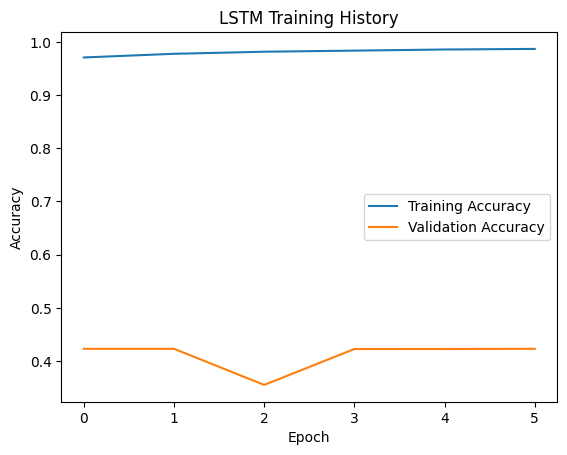

In [ ]:
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("lstm_training_history")

In [ ]:
# Membuat model RNN untuk multi-kelas tanpa data dari Autoencoder
# encoding_dim = 78
# rnn_model = tf.keras.Sequential([
#     layers.Input(shape=(encoding_dim,)),
#     layers.Reshape((encoding_dim, 1)),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.4),
#     layers.LSTM(128),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')  # Output layer untuk multi-kelas
# ])

# # Compile RNN
# rnn_model.compile(optimizer='adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])

# # Training RNN dengan early stopping
# early_stopping_rnn = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=5,
#     restore_best_weights=True
# )

# print("\nTraining RNN...")
# history_rnn = rnn_model.fit(X_train, y_train,
#                            epochs=50,
#                            batch_size=512,
#                            validation_split=0.2,
#                            callbacks=[early_stopping_rnn])


In [ ]:
rnn_model.summary()

## Evaluasi Model pada Data Test

In [ ]:
X_test, y_test = transform_data(X_test, y_test, scaler, imputer, le)
X_test_encoded = encoder.predict(X_test)

In [ ]:
Evaluasi model
y_pred = rnn_model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Tampilkan hasil evaluasi
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("ae_plot_history")

In [ ]:
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("lstm_training_history")

In [ ]:
# # Plot confusion matrix
# plt.figure(figsize=(12, 10))
# cm = confusion_matrix(y_test_classes, y_pred_classes)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=le.classes_,
#             yticklabels=le.classes_)
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)
# plt.tight_layout()
# plt.show()
# plt.savefig("confusion_matrix")


In [ ]:
# Simpan model
print("\nMenyimpan model...")
autoencoder.save('autoencoder_model.h5')
encoder.save('encoder_model.h5')
rnn_model.save('rnn_model.h5')

In [ ]:
# Simpan label encoder
import joblib
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')

---